In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
plt.style.use('dark_background')
from data_load_preprocess import data

import torch
from torch.autograd import Variable
from viz import viz

/accounts/projects/vision/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# load results from a directory

In [2]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk'
print(os.listdir(out_dir_main))
folder = 'sweep_init_d=1_concentrated'

['sweep_init_d=1_concentrated', 'sweep_init_d=6_centered_long', 'sweep_init_small_centered', 'sweep_init_d=10_concentrated', 'sweep_init_small', 'sweep_init_large']


In [ ]:
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
results.describe()

# compare losses by hidden layer dim

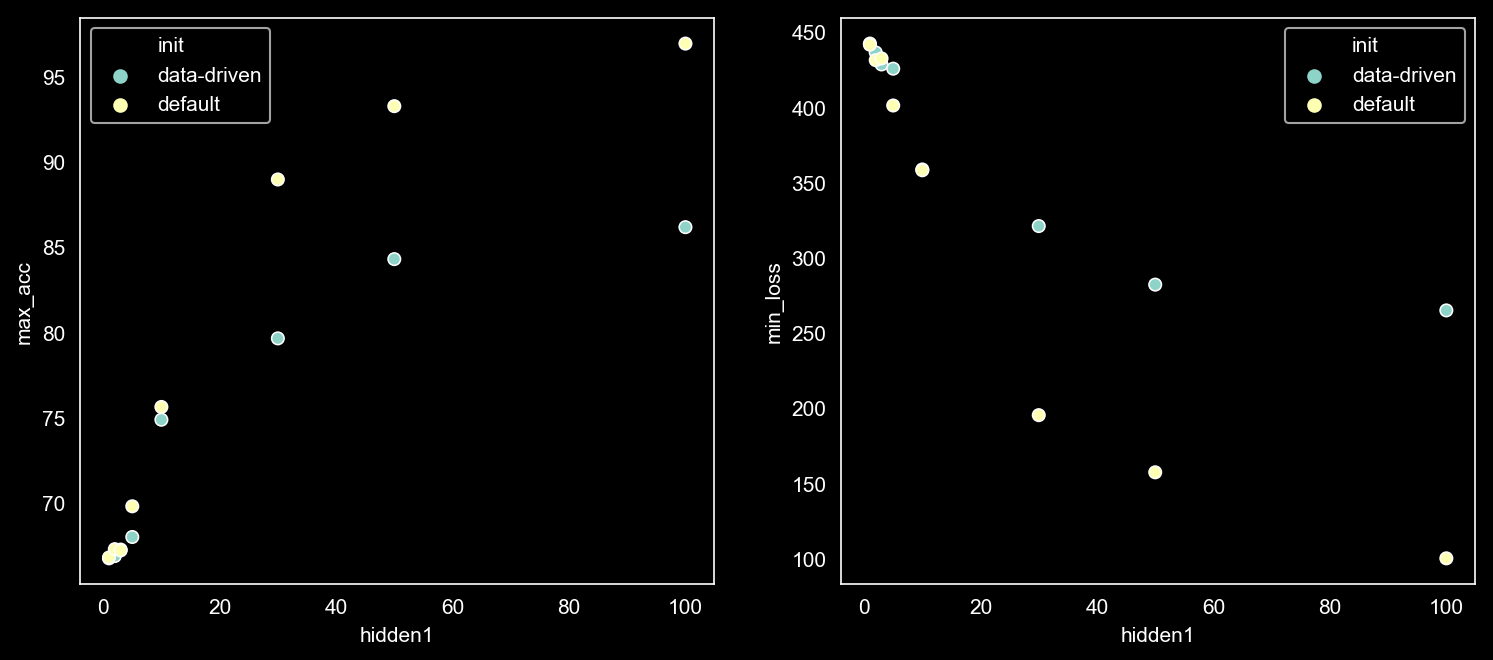

In [65]:
max_accs_default = results[results['init']=='default'].groupby(['hidden1']).mean().reset_index()
max_accs_data = results[results['init']=='data-driven'].groupby(['hidden1']).mean().reset_index()
max_accs_data['init'] = 'data-driven'
max_accs_default['init'] = 'default'
max_accs = pd.concat([max_accs_data, max_accs_default]) # todo: there's probably a nicer way to do this in pd


fig, ax = plt.subplots(figsize=(12, 5), dpi=150, ncols=2, nrows=1)
sns.scatterplot(x='hidden1', y='max_acc', data=max_accs, ax=ax[0], hue="init")

sns.scatterplot(x='hidden1', y='min_loss', data=max_accs, ax=ax[1], hue="init")
plt.show()

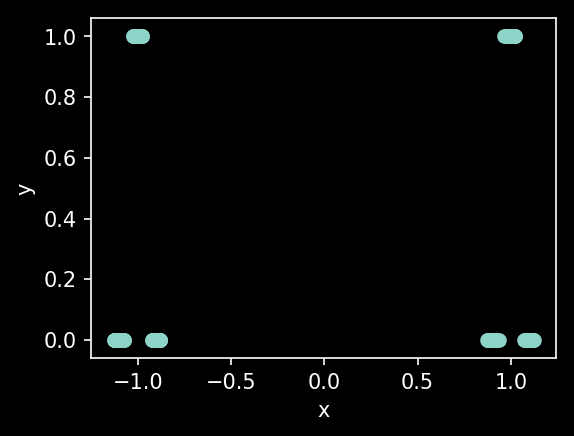

In [48]:
# plot data (only 1d)
X, y_onehot, y_scalar = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
plt.figure(figsize=(4, 3), dpi=150)
viz.plot_data(X, y_scalar)

# kink analysis

In [ ]:
results_default = results[results['init']=='default']
results_data = results[results['init']=='data-driven']

means = results.means[0]
preds = results[['X_test', 'losses', 'pred_test','weights', 'max_acc', 'hidden1']].groupby(['hidden1'])

maxidx = max(results.weights[0].keys())
minidx = min(results.weights[0].keys())

num_samples = 100
rows, cols = 4, 2
plt.figure(figsize=[4*cols, 4*rows], dpi=150)
i = 1
for h in [1, 5, 10, 50]:
    plt.subplot(rows, cols, i)
    i+=1    
    pl = preds.get_group(h).sample(num_samples)['weights']
    for key in pl.keys():
        temp = pl[key]
        relus0 = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        relusf = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        plt.scatter(relus0, relusf, s=10.)
        for mean in means:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
            plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlabel('init')
        plt.ylabel('final')
        plt.title('kinks default, h=%d'%(h))
    

    plt.subplot(rows, cols, i)
    i+=1
    ps = preds.get_group(h).sample(num_samples)['weights']    
    for key in ps.keys():
        temp = ps[key]
        relus0 = -temp[minidx]['0.bias']/temp[minidx]['0.weight'].flatten()
        relusf = -temp[maxidx]['0.bias']/temp[maxidx]['0.weight'].flatten()
        plt.scatter(relus0, relusf, s=10.)
        for mean in means:
            plt.axvline(x=mean, linestyle='--', linewidth=0.5)
            plt.axhline(y=mean, linestyle='--', linewidth=0.5)
        plt.xlabel('init')
        plt.ylabel('final')            
        plt.title('kinks data-driven, h=%d'%(h))

plt.show()